# Probability difference thingies

Futzing around with views that show probability differences and histograms

In [1]:
%matplotlib inline
import sys
import os
import logging
import numpy
import pandas
import matplotlib
from matplotlib import pyplot
import seaborn
import sklearn
import sklearn.metrics

from metric_querier import ELAsTiCCMetricsQuerier

In [2]:
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    logger.addHandler( _logout )
    _formatter = logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S' )
    _logout.setFormatter( _formatter )

logger.setLevel( logging.DEBUG )

In [3]:
tomurl = 'https://desc-tom.lbl.gov'
# tomurl = 'https://desc-tom-rknop-dev.lbl.gov'
username = "rknop"
with open( os.path.join( os.getenv("HOME"), "secrets", "tom_"+username+"_passwd") ) as ifp:
    password = ifp.readline().strip()
    
emq = ELAsTiCCMetricsQuerier( tomusername=username, tompasswd=password, url=tomurl, logger=logger )

In [4]:
diffhist = emq.right_probdiffs_hist()
diffhist

[2023-04-06 07:03:19 - DEBUG] - Sending query to get the probability differences histogram thingy
[2023-04-06 07:03:21 - DEBUG] - Query done, pandafying


earlytimet0  \
classifierId trueClassId earlytimebin latetimebin probdiffbin                
38           111         3            7           5                    0.0   
                                                  11                   0.0   
                                                  12                   0.0   
                                                  13                   0.0   
                                                  14                   0.0   
...                                                                    ...   
63           221         5            13          32                  20.0   
                                                  33                  20.0   
                                                  34                  20.0   
                                                  35                  20.0   
                                                  36                  20.0   

                                                               earlytimet1  \
classifierId trueClassId earlytimebin latetimebin probdiffbin                
38           111         3            7           5                   10.0   
                                                  11                  10.0   
                                                  12                  10.0   
                                                  13                  10.0   
                                                  14                  10.0   
...                                                                    ...   
63           221         5            13          32                  30.0   
                                                  33                  30.0   
                                                  34                  30.0   
                                                  35                  30.0   
                                                  36                  30.0   

                                                               latetimet0  \
classifierId trueClassId earlytimebin latetimebin probdiffbin               
38           111         3            7           5                  40.0   
                                                  11                 40.0   
                                                  12                 40.0   
                                                  13                 40.0   
                                                  14                 40.0   
...                                                                   ...   
63           221         5            13          32                100.0   
                                                  33                100.0   
                                                  34                100.0   
                                                  35                100.0   
                                                  36                100.0   

                                                               latetimet1  \
classifierId trueClassId earlytimebin latetimebin probdiffbin               
38           111         3            7           5                  50.0   
                                                  11                 50.0   
                                                  12                 50.0   
                                                  13                 50.0   
                                                  14                 50.0   
...                                                                   ...   
63           221         5            13          32             999999.0   
                                                  33             999999.0   
                                                  34             999999.0   
                                                  35             999999.0   
                                                  36             999999.0   

                             

In [5]:
diffhist.earlytimet0.dtype

dtype('float64')

In [15]:
earlytimebin = 3
latetimebin = 9
classifierId = 42
trueClassId = 111

# Pull out the dataframe for just this class, classifier, and pair of time ranges
subdf = diffhist.xs( ( earlytimebin, latetimebin, classifierId, trueClassId ),
                     level=( 'earlytimebin', 'latetimebin', 'classifierId', 'trueClassId' ) )
subdf = subdf[ [ 'binmeanprobdiff', 'count', 'frac' ] ]
# Fill in missing time values with zeros
subdf = subdf.reindex( index=range(1,41), fill_value=0 )
w = ( subdf['binmeanprobdiff'] == 0 )
subdf.loc[w, 'binmeanprobdiff'] = emq.right_probdiffs_hist_probbin_mean( subdf[w].index.values )
# Convenience for titles
earlytimet0 = subdf.iloc[0]['earlytimet0']
earlytimet1 = subdf.iloc[0]['earlytimet1']
latetimet0 = subdf.iloc[0]['latetimet0']
latetimet1 = subdf.iloc[0]['latetimet1']


KeyError: 'earlytimet0'

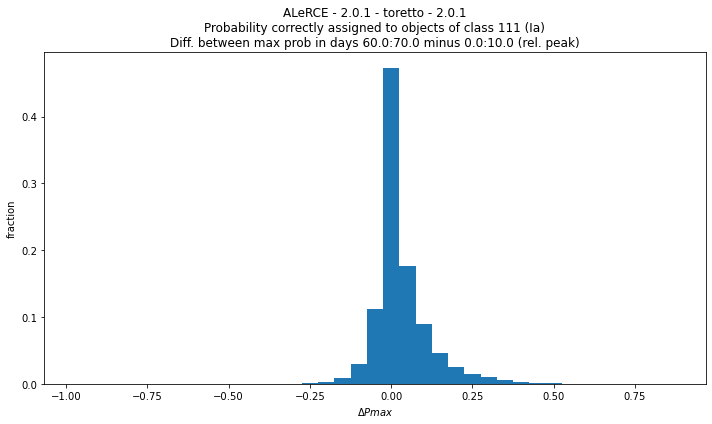

In [12]:
fig = pyplot.figure( figsize=(10,6), tight_layout=True )
ax = fig.add_subplot( 1, 1, 1 )
cfer = emq.classifier_info[classifierId]
ax.set_title( f"{cfer['brokerName']} - {cfer['brokerVersion']} - {cfer['classifierName']} - {cfer['classifierParams']}\n"
              f"Probability correctly assigned to objects of class {trueClassId} ({emq.classname[trueClassId]})\n"
              f"Diff. between max prob in days {latetimet0}:{latetimet1} minus {earlytimet0}:{earlytimet1} (rel. peak)" )
ax.set_xlabel( r"$\Delta Pmax$" )
ax.set_ylabel( "fraction" )
ax.bar( subdf.binmeanprobdiff.values[1:-2], subdf.frac.values[1:-2], width=0.05, align='center' )
# TODO : plot first and last bins half-width, edge-aligned
fig.show()

In [14]:
subdf.frac.sum()

1.0